# QT3 AFM Lab Image Processing Software Demo

Build the Thorlabs Educational Atomic Force Microscope according to the provided manual.
Understand the steps to engage the probe with the sample. 


#### Taking an AFM scan and saving the file
Once the probe properly is engaged with the sample, take scans in Constant Force mode and observe the effect of different scan parameters such as Strain Gauge and resolution. Once a scan is complete, save the data as both an image and a csv file to an appropriate folder using the following format: 
###### parameter1Value1_parameter2Value2_parameter3Value3 (eg. nameMyScan_res250_speed100_modeConstantForce_straingauge)
This format is necessary for the software to identify the parameters of the scan. A parameter should be added to the file name if it is different from the default value. The parameters and default values are as according to the attributes defined in the ScanData class. Make sure you record each parameter correctly and with the correct spelling. Recommended order is according to how each is listed in the class, but order does not affect the operation of the software. Capitalization is optional but helpful for reading. Parameters that are either on or off only need to be in the file name if they are on for the scan and need only the parameter and no value. The last four attributes are not used in naming the file. Scans should be placed in the same folder if the data will be compared to one another

#### Identify and image features
Take a scan of the supplied microstructure in Constant Force mode with Strain Gauge and with 100px resolution at 100pps. The resolution of this image is not important because this scan is only for locating features. Once you see the feature you would like to look at closer, stop the scan and use the Zoom feature to take a closer scan of the desired feature with 250px resolution. Use the shift key while dragging to make sure you are taking a square window. If you need to restart the zoom scan, you have to reselect the zoom window because the start coordinates of the scan are not saved. When saving the data for a zoom scan, make sure to record the width of the zoom window to the file name using the width parameter (width3.0 corresponds to a zoom window of 3 microns by 3 microns).

#### Using the software
Import the necessary libraries and functions from the scandata file. Get scan data from your folder.

In [1]:
from matplotlib import pyplot as plt
import numpy as np

from scandata import get_scan_data_from_directory, get_step_volts_for_calibration

afmscans = get_scan_data_from_directory('TestSpeed')

Calibrate the height by calculating the volts per nm factor

In [2]:
volts = []
for afmscan in afmscans:
    volts.append(afmscan.get_edge().data_slice)

step_voltage = get_step_volts_for_calibration(volts)

for afmscan in afmscans:
    afmscan.cf_calibrate = step_voltage / 114


Plot an edge of each file to locate the coordinates of the step. For each edge, record the top and bottom coordinates of the step using the graph. Lists of coordinates of maxima and minima are provided to make this easier. It is helpful to separate the coordinates into forward and backward scans.

Backward Scan: False
Maxima: [0.0204 0.0408 0.102  0.272  0.374  0.4556 0.5848 0.8704 1.1696 1.2512
 1.2716 1.292  1.4688 1.6388]
Minima: [0.034  0.0476 0.2652 0.3672 0.4488 0.5644 0.6868 1.1628 1.2308 1.258
 1.2852 1.462  1.632 ]


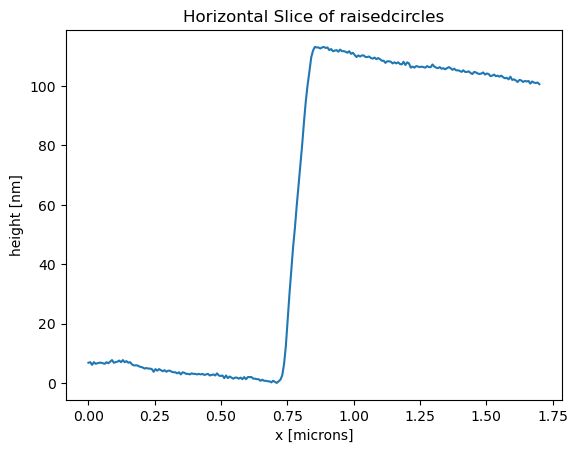

Top Coordinate:  0.8704
Bottom Coordinate:  0.6868


Backward Scan: True
Maxima: [0.2856 0.306  0.816  0.8432 1.2784 1.292  1.3124 1.564  1.6592]
Minima: [0.2516 0.2924 0.6324 0.8364 1.2716 1.2852 1.3056 1.5572 1.6524]


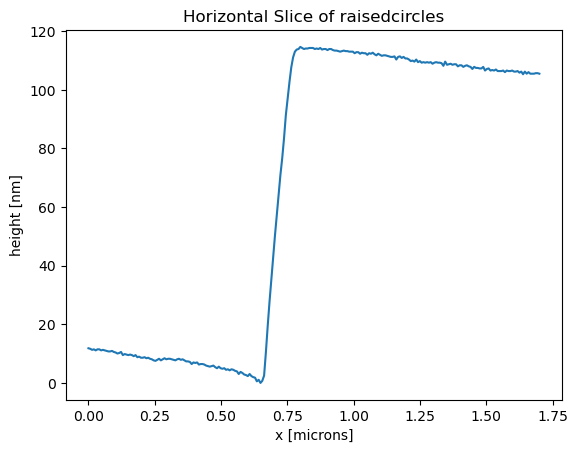

Top Coordinate:  0.816
Bottom Coordinate:  0.632


Backward Scan: False
Maxima: [0.0504 0.1656 0.2304 1.0584 1.6776 1.692  1.7136 1.7352 1.7568]
Minima: [0.0432 0.1152 0.2232 0.8496 1.656  1.6848 1.7064 1.728  1.7496]


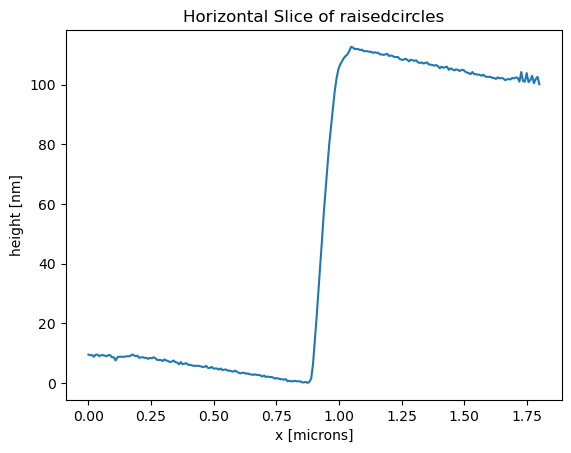

Top Coordinate:  1.0584
Bottom Coordinate:  0.8496


Backward Scan: True
Maxima: [0.3528 0.7416 0.9936 1.0512 1.332  1.476  1.512  1.5264 1.548  1.692
 1.7352]
Minima: [0.3456 0.7344 0.7848 1.044  1.3248 1.4688 1.5048 1.5192 1.5408 1.6848
 1.728 ]


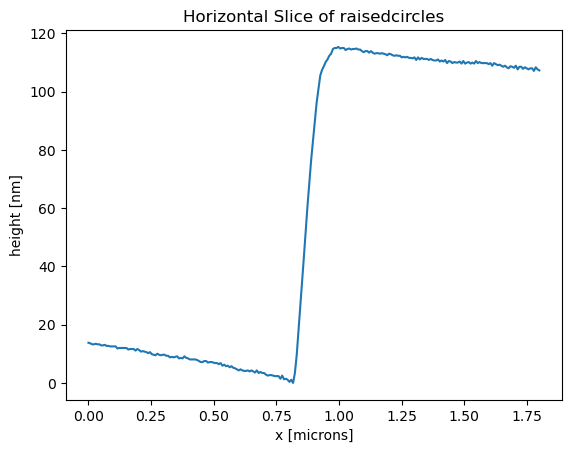

Top Coordinate:  0.9936
Bottom Coordinate:  0.7848


Backward Scan: False
Maxima: [0.0612 0.102  0.1224 0.136  0.1836 0.612  0.6256 0.6528 0.6664 0.8024
 1.088  1.2172 1.36   1.4688 1.632 ]
Minima: [0.0544 0.068  0.1156 0.1292 0.1428 0.6052 0.6188 0.6392 0.6596 0.7208
 0.8908 1.19   1.3532 1.4552 1.6252]


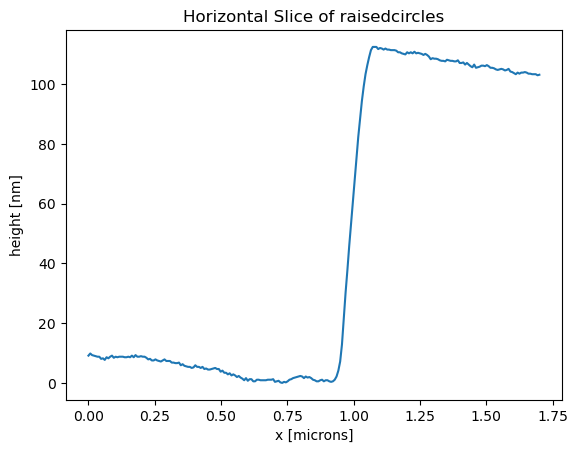

Top Coordinate:  1.088
Bottom Coordinate:  0.908


Backward Scan: True
Maxima: [0.0816 0.102  0.476  0.5236 0.5508 0.5644 0.7072 0.7276 0.7548 0.7684
 0.9996 1.0812 1.1492 1.258  1.394  1.4212 1.4688 1.496  1.5096 1.666 ]
Minima: [0.0748 0.0884 0.4556 0.5168 0.544  0.5576 0.6936 0.714  0.7412 0.7616
 0.8092 1.0676 1.088  1.2172 1.3736 1.4144 1.462  1.4756 1.5028 1.6592]


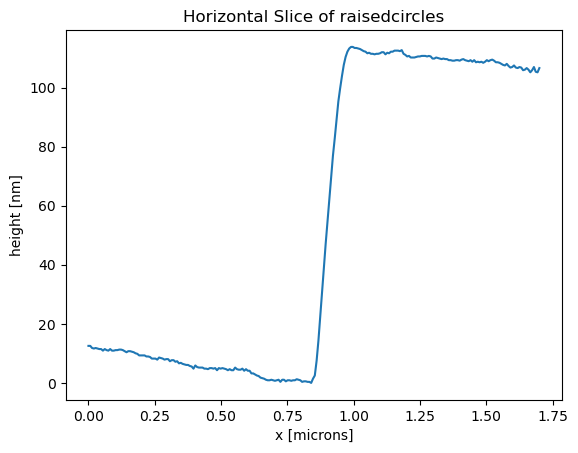

Top Coordinate:  0.9996
Bottom Coordinate:  0.8092


Backward Scan: False
Maxima: [0.0288 0.0576 0.1512 0.18   0.2016 0.684  0.9792 1.2528 1.3248 1.3536
 1.3968]
Minima: [0.0504 0.144  0.1728 0.1944 0.6696 0.7632 1.2456 1.3176 1.3464 1.3896]


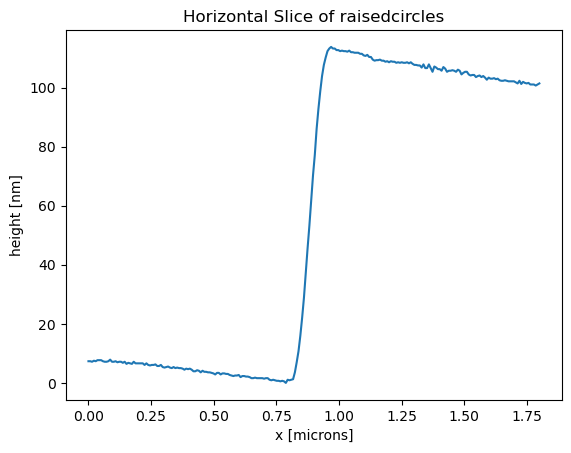

Top Coordinate:  0.9792
Bottom Coordinate:  0.7632


Backward Scan: True
Maxima: [0.1008 0.1224 0.4536 0.8784 0.9432 0.9936 1.2456 1.2744 1.3032 1.332
 1.368  1.3968 1.6488 1.6704 1.6992 1.728 ]
Minima: [0.0936 0.1152 0.4464 0.6768 0.936  0.9864 1.2312 1.26   1.2888 1.3176
 1.3608 1.3896 1.6416 1.6632 1.692  1.7136 1.764 ]


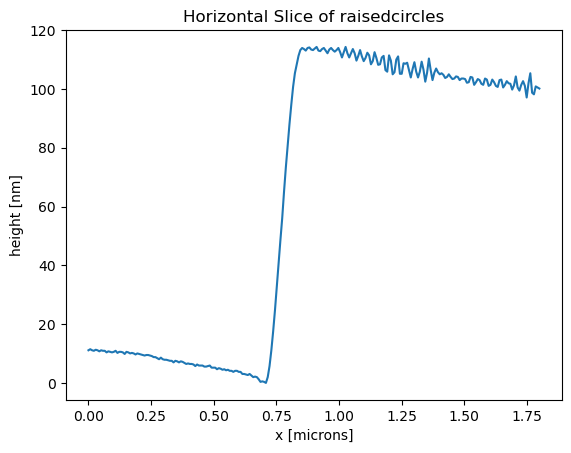

Top Coordinate:  0.8784
Bottom Coordinate:  0.6768


Backward Scan: False
Maxima: [0.076  0.0988 0.1292 0.3724 0.8132 1.3832 1.3984 1.4516 1.5048 1.5428
 1.6264 1.6492 1.6796 1.6948 1.71   1.7404 1.7632 1.786 ]
Minima: [0.0684 0.0912 0.1216 0.3648 0.6384 1.368  1.3908 1.444  1.482  1.52
 1.6188 1.634  1.6568 1.6872 1.7024 1.7328 1.7556 1.7708]


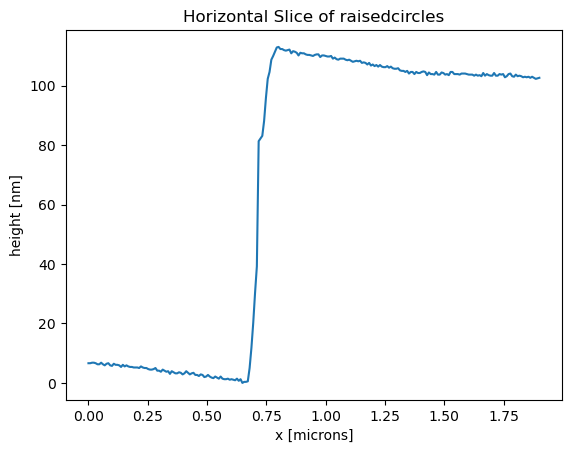

Top Coordinate:  0.8132
Bottom Coordinate:  0.6384


Backward Scan: True
Maxima: [0.7828 0.8512 1.0032 1.0336 1.0564 1.216  1.2464 1.3756 1.7024 1.7328
 1.7556]
Minima: [0.5244 0.8436 0.9956 1.026  1.0488 1.2084 1.2312 1.254  1.6948 1.7252
 1.748  1.7784]


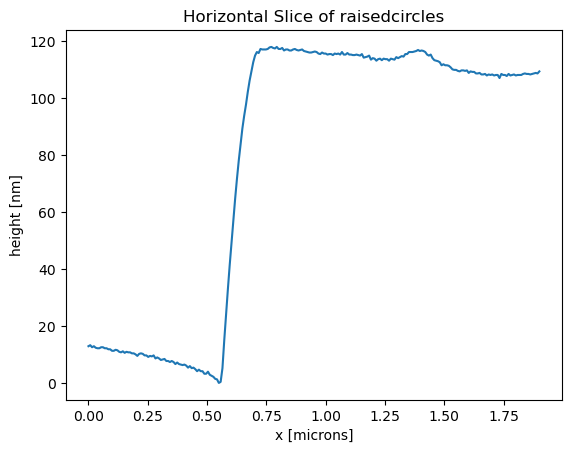

Top Coordinate:  0.7828
Bottom Coordinate:  0.5244


Backward Scan: False
Maxima: [0.0272 0.1496 0.272  0.4012 0.5032 0.5916 0.8092 0.85   0.9112 0.9724
 1.0948 1.1356 1.2988 1.4756 1.5164 1.564 ]
Minima: [0.068  0.204  0.3604 0.4556 0.5372 0.6256 0.8296 0.8568 0.9656 1.0336
 1.122  1.224  1.4348 1.4892 1.5232 1.6252]


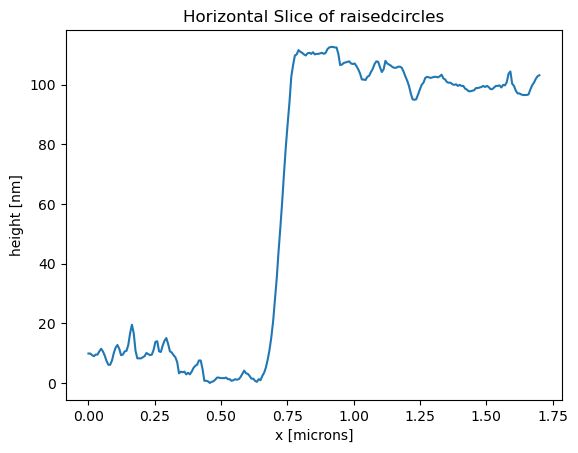

Top Coordinate:  0.8092
Bottom Coordinate:  0.6256


Backward Scan: True
Maxima: [0.034  0.0816 0.1632 0.1768 0.2516 0.3604 0.3876 0.4148 0.5984 0.8364
 0.8636 0.9316 1.0336 1.0812 1.2308 1.2648 1.4076 1.4416 1.5096]
Minima: [0.0612 0.136  0.17   0.2244 0.3332 0.3808 0.408  0.5916 0.6256 0.8568
 0.8908 1.0268 1.0472 1.224  1.2376 1.3124 1.428  1.5028 1.6524]


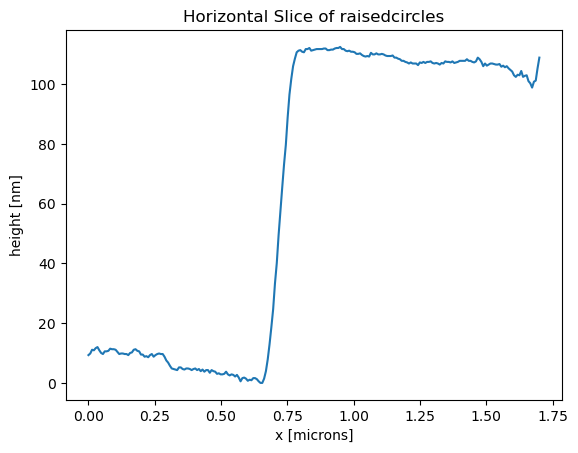

Top Coordinate:  0.8364
Bottom Coordinate:  0.6256


Backward Scan: False
Maxima: [0.032  0.064  0.1408 0.1536 0.1856 0.2112 0.2432 0.2752 0.3072 0.3392
 0.3712 0.3968 0.4544 0.4864 0.544  0.7232 0.9088 0.9344 1.1456]
Minima: [0.0192 0.0512 0.1344 0.1472 0.1728 0.2048 0.2368 0.2688 0.2944 0.3264
 0.3584 0.3904 0.448  0.4736 0.5376 0.7168 0.9024 0.928  0.9664]


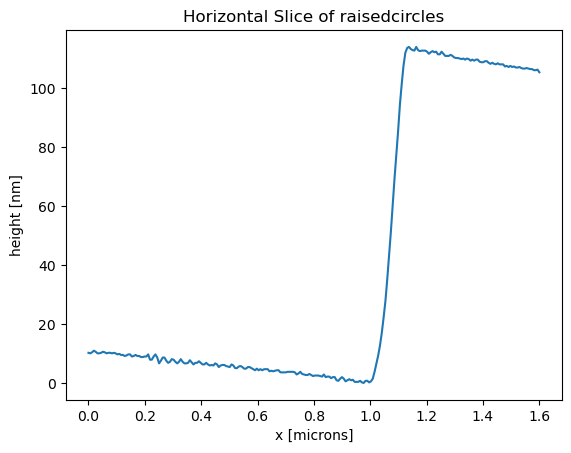

Top Coordinate:  1.1456
Bottom Coordinate:  0.9664


Backward Scan: True
Maxima: [0.1152 0.2048 0.3712 1.0688 1.2288 1.248  1.3952 1.4144]
Minima: [0.1088 0.1984 0.3648 0.8512 1.2224 1.2416 1.3888 1.408  1.568 ]


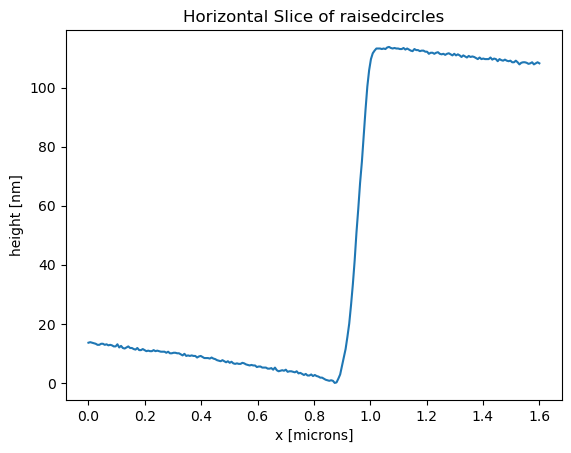

Top Coordinate:  1.0688
Bottom Coordinate:  0.8512


Backward Scan: False
Maxima: [0.0216 0.4176 0.4824 0.5616 0.8496 1.476  1.5048 1.5408 1.5768 1.6128
 1.6488 1.6776 1.7136 1.7496]
Minima: [0.4104 0.4752 0.5544 0.6336 1.4544 1.4904 1.5264 1.5624 1.5984 1.6272
 1.6632 1.6992 1.7352]


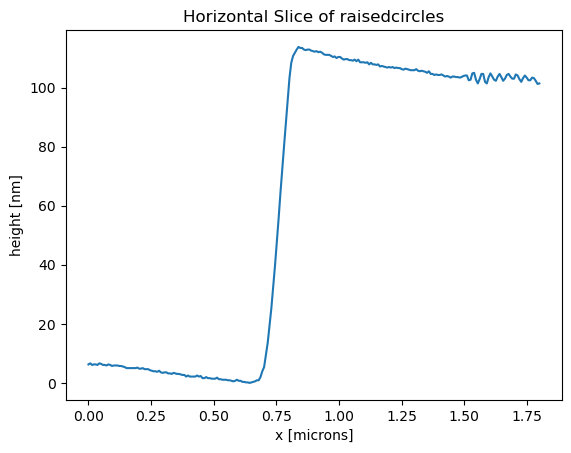

Top Coordinate:  0.8496
Bottom Coordinate:  0.6336


Backward Scan: True
Maxima: [0.7344 0.7488 0.7632 1.1232 1.1592 1.2888 1.4544 1.4904 1.5264 1.5552
 1.6272]
Minima: [0.5328 0.7416 0.756  1.116  1.1448 1.2816 1.4472 1.4688 1.512  1.548
 1.6128 1.7424]


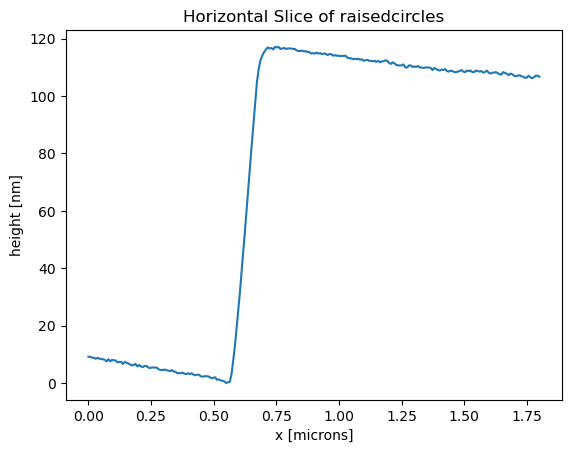

Top Coordinate:  0.7344
Bottom Coordinate:  0.5328


Backward Scan: False
Maxima: [0.032  0.0448 0.0704 0.1536 0.224  0.2496 0.2624 0.32   0.3584 0.4288
 0.9984 1.4528]
Minima: [0.0192 0.0384 0.0512 0.1472 0.2176 0.2432 0.256  0.3136 0.352  0.4224
 0.6784 1.4464]


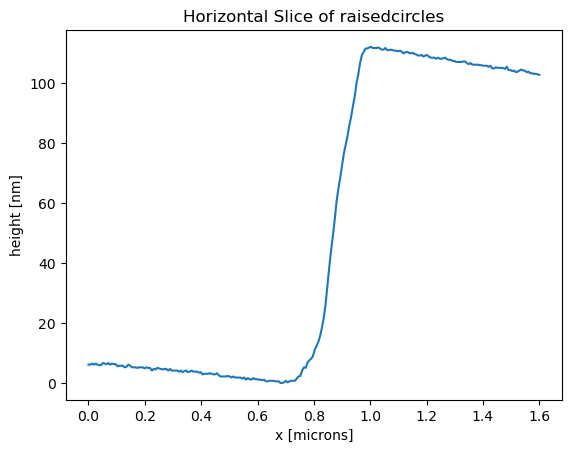

Top Coordinate:  0.9984
Bottom Coordinate:  0.6784


Backward Scan: True
Maxima: [0.1024 0.1216 0.1792 0.192  0.2368 0.576  0.5888 0.896  0.9088 0.928
 0.9664 0.9984 1.2928 1.4336 1.5552]
Minima: [0.096  0.1152 0.1728 0.1856 0.2304 0.5696 0.5824 0.5952 0.9024 0.9216
 0.96   0.992  1.2864 1.4272 1.5488 1.5616]


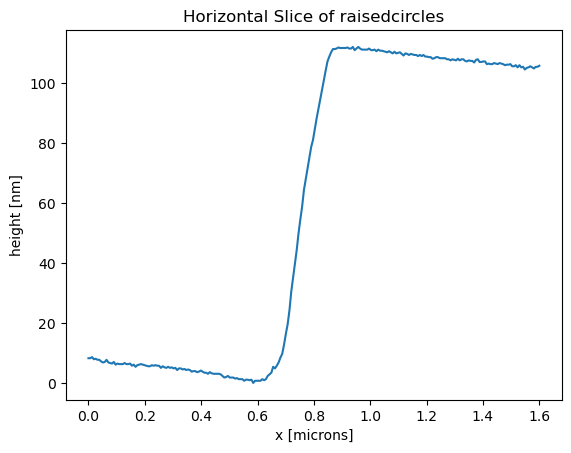

Top Coordinate:  0.896
Bottom Coordinate:  0.5952


Backward Scan: False
Maxima: [0.0256 0.064  0.1408 0.1728 0.2624 0.3264 0.352  0.7104 1.0624 1.2416
 1.5104 1.5488]
Minima: [0.0192 0.0576 0.1216 0.1664 0.256  0.32   0.3456 0.4352 1.056  1.2288
 1.4976 1.5296]


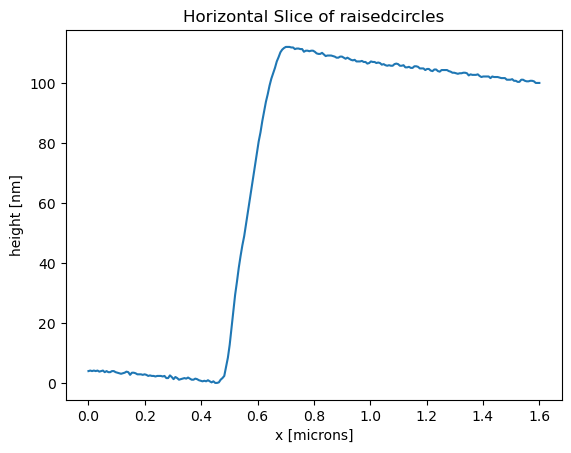

Top Coordinate:  0.7104
Bottom Coordinate:  0.4352


Backward Scan: True
Maxima: [0.5824 0.6208 0.736  1.0816 1.4016 1.4208]
Minima: [0.3136 0.608  0.7296 1.0752 1.3952 1.4144 1.568 ]


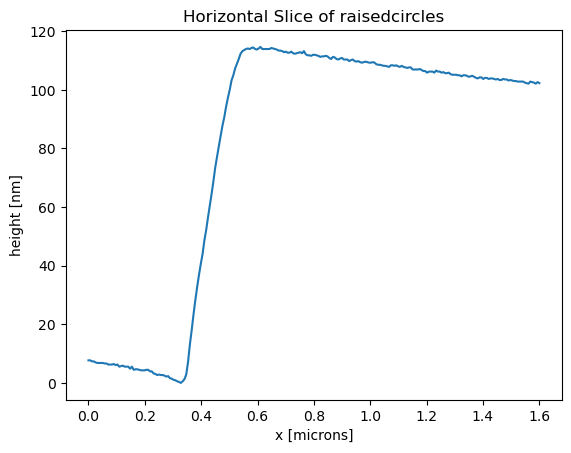

Top Coordinate:  0.5824
Bottom Coordinate:  0.3136


Backward Scan: False
Maxima: [0.0504 0.1224 0.1728 0.3024 0.4752 0.4968 0.5328 0.612  0.648  0.6912
 0.8496 0.9792 1.0728 1.224  1.5408 1.6128]
Minima: [0.036  0.1152 0.1296 0.2448 0.4464 0.4896 0.5256 0.5976 0.6408 0.684
 0.792  0.936  1.044  1.2168 1.296  1.548 ]


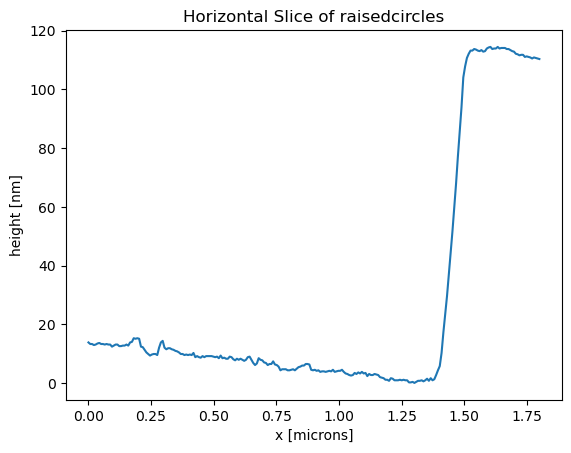

Top Coordinate:  1.5408
Bottom Coordinate:  1.5192


Backward Scan: True
Maxima: [0.0432 0.2016 0.2304 0.2448 0.3744 0.5544 0.612  0.6624 0.8136 0.8928
 1.188  1.2312 1.2528 1.5192 1.5552 1.6344]
Minima: [0.036  0.1512 0.2232 0.2376 0.3168 0.4968 0.6048 0.6264 0.72   0.8712
 1.1592 1.1952 1.2384 1.3464 1.548  1.5768 1.7424]


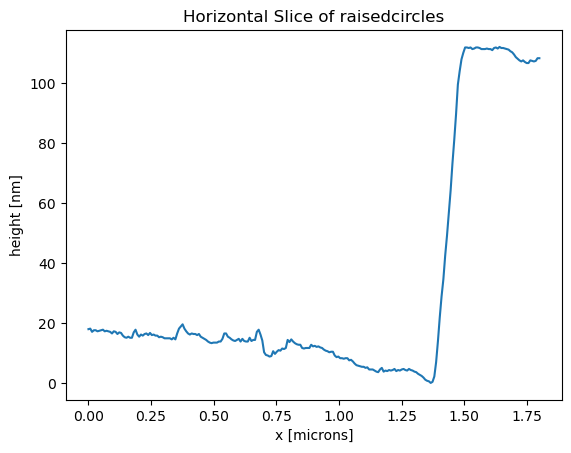

Top Coordinate:  1.5192
Bottom Coordinate:  1.3464


Backward Scan: False
Maxima: [0.0216 0.0648 0.1584 0.1728 0.252  0.2736 0.4896 0.6768 0.7056 0.9072
 0.9792 1.2528 1.4688 1.4976 1.5264]
Minima: [0.0504 0.144  0.1656 0.2448 0.2664 0.4608 0.6696 0.6984 0.8568 0.9648
 1.0728 1.4616 1.4904 1.5048]


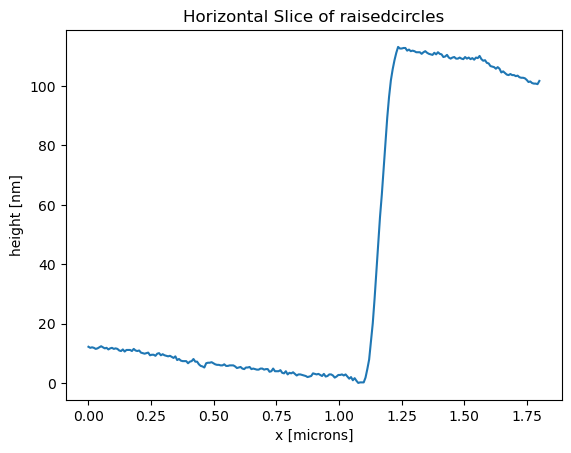

Top Coordinate:  1.2528
Bottom Coordinate:  1.0728


Backward Scan: True
Maxima: [0.1944 0.2448 0.2952 0.3168 0.3456 0.3672 0.396  0.4176 0.4392 0.468
 0.4896 0.5112 0.828  0.8496 1.224  1.3248 1.368  1.584  1.6128]
Minima: [0.1872 0.2376 0.2808 0.3096 0.3312 0.3528 0.3816 0.4032 0.432  0.4536
 0.4752 0.504  0.8208 0.8424 1.044  1.3176 1.332  1.5768 1.6056 1.7208]


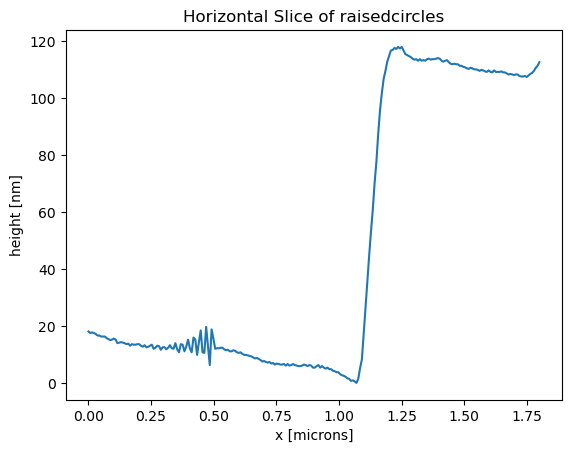

Top Coordinate:  1.224
Bottom Coordinate:  1.044


Backward Scan: False
Maxima: [0.1088 0.2944 0.384  0.64   0.8064 0.9216 1.088  1.1008 1.1136 1.1712
 1.4336]
Minima: [0.2368 0.3328 0.4544 0.7488 0.896  1.0816 1.0944 1.1072 1.1648 1.4144]


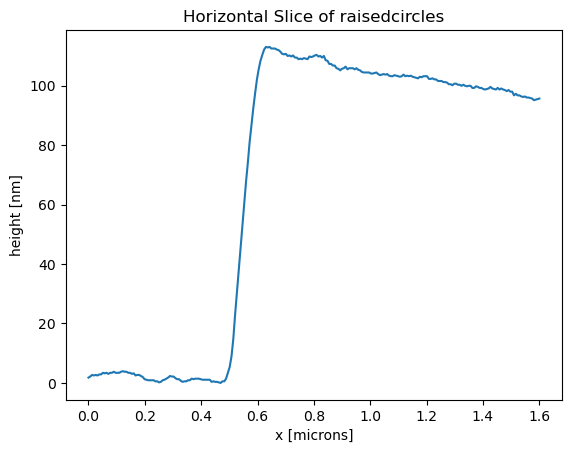

Top Coordinate:  0.64
Bottom Coordinate:  0.4544


Backward Scan: True
Maxima: [0.0192 0.032  0.1024 0.1152 0.128  0.1408 0.608  0.6208 0.6336 0.6464
 0.6592 0.672  0.6848 0.704  0.7168 0.7296 0.7424 0.768  0.9344 1.0432
 1.0688 1.1328 1.1456 1.1648 1.1904 1.3056 1.4912]
Minima: [0.0256 0.0384 0.1088 0.1216 0.1344 0.4224 0.6144 0.6272 0.64   0.6528
 0.6656 0.6784 0.6976 0.7104 0.7232 0.736  0.7488 0.9088 1.0176 1.0624
 1.12   1.1392 1.1584 1.184  1.2672 1.4784 1.5552]


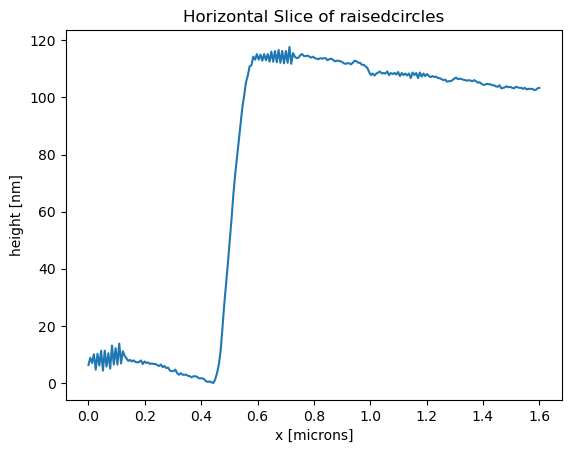

Top Coordinate:  0.608
Bottom Coordinate:  0.4224


[(0.8704, 0.6868), (1.0584, 0.8496), (1.088, 0.908), (0.9792, 0.7632), (0.8132, 0.6384), (0.8092, 0.6256), (1.1456, 0.9664), (0.8496, 0.6336), (0.9984, 0.6784), (0.7104, 0.4352), (1.5408, 1.5192), (1.2528, 1.0728), (0.64, 0.4544)]
[(0.816, 0.632), (0.9936, 0.7848), (0.9996, 0.8092), (0.8784, 0.6768), (0.7828, 0.5244), (0.8364, 0.6256), (1.0688, 0.8512), (0.7344, 0.5328), (0.896, 0.5952), (0.5824, 0.3136), (1.5192, 1.3464), (1.224, 1.044), (0.608, 0.4224)]


In [14]:
steps = []
back_steps = []

for afmscan in afmscans:
    print("Backward Scan: " + str(afmscan.backward))
    afmscan.get_edge().volt_to_height().find_features().plot_edge()
    plt.show()
    top = float(input("Top Coordinate: "))
    bottom = float(input("Bottom Coordinate: "))
    if afmscan.backward:
        back_steps.append((top, bottom))
    else:
        steps.append((top, bottom))

print('steps: ', str(steps), 'back_steps: ', back_steps, sep='\n')

Using the lists of tuples you created, plot the step width and rms noise for each scan against the scan speed.

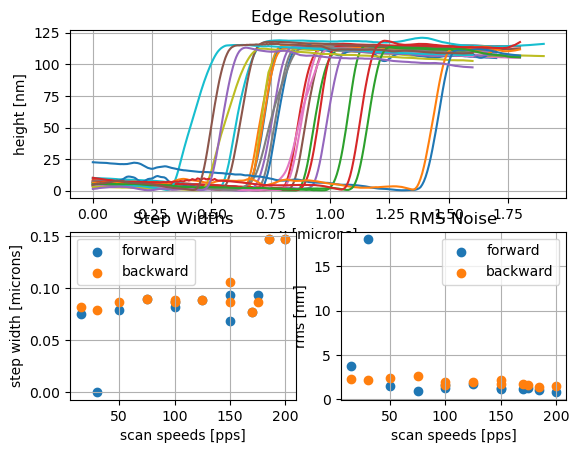

In [15]:
# steps = [(0.8704, 0.6868), (1.0584, 0.8496), (1.0888, 0.908), (0.9792, 0.7632), (0.8132, 0.6384), (0.8092, 0.6256),
#          (1.1456, 0.9664), (0.8496, 0.6336), (0.9984, 0.6784), (0.7104, 0.4352), (1.5408, 1.296), (1.2528, 1.0728),
#          (0.64, 0.4544)]
# back_steps = [(0.816, 0.6324), (0.9936, 0.7848), (0.9996, 0.8092), (0.8784, 0.6768), (0.7828, 0.5244), (0.8364, 0.6256),
#               (1.0688, 0.8512), (0.7344, 0.5328), (0.896, 0.5952), (0.5824, 0.3136), (1.5192, 1.3464), (1.224, 1.044),
#               (0.608, 0.4224)]

# empty lists for plotting
step_widths, back_step_widths, scan_speeds, back_scan_speeds, scan_rms, back_scan_rms, scan_pid, back_scan_pid \
    = [[] for _ in range(8)]
# create plots
fig = plt.figure()
ax1 = plt.subplot2grid(shape=(2, 2), loc=(0, 0), colspan=2)
ax2 = plt.subplot2grid(shape=(2, 2), loc=(1, 0))
ax3 = plt.subplot2grid(shape=(2, 2), loc=(1, 1))
axs = (ax1, ax2, ax3)
[ax.grid(True) for ax in axs]
# fill empty lists with data and plot the edge
for afmscan, step in zip(afmscans, [item for pair in zip(steps, back_steps) for item in pair]):
    afmscan.get_edge().volt_to_height().tilt_correct((0, step[1]))
    # backward scans
    if afmscan.backward:
        back_scan_speeds.append(afmscan.speed)
        back_step_widths.append(afmscan.get_step_width(step))
        back_scan_rms.append(afmscan.get_noise((0, step[1])))
        back_scan_pid.append(afmscan.pid[0])
    # forward scans
    else:
        scan_speeds.append(afmscan.speed)
        step_widths.append(afmscan.get_step_width(step))
        scan_rms.append(afmscan.get_noise((0, step[1])))
        scan_pid.append(afmscan.pid[0])
    # plot slice of edge
    ax1.plot(np.linspace(0, afmscan.width, afmscan.res), afmscan.denoise())

ax1.set_title('Edge Resolution')
ax1.set_xlabel('x [microns]')
ax1.set_ylabel('height [nm]')

# plot step width against scan speed
[ax2.scatter(x, y, label=direction) for x, y, direction in
 zip([scan_speeds, back_scan_speeds], [step_widths, back_step_widths], ['forward', 'backward'])]
ax2.set_title('Step Widths')
ax2.set_xlabel('scan speeds [pps]')
ax2.set_ylabel('step width [microns]')
ax2.legend()
# plot rms noise against scan speed
[ax3.scatter(x, y, label=direction) for x, y, direction in
 zip([scan_speeds, back_scan_speeds], [scan_rms, back_scan_rms], ['forward', 'backward'])]
ax3.set_title('RMS Noise')
ax3.set_xlabel('scan speeds [pps]')
ax3.set_ylabel('rms [nm]')
ax3.legend()

plt.show()

Observe any patterns in step width and rms noise as the scan speed changes